# Cell-Type Specific Differential Gene Expression Analysis of scRNA-seq Data in Alzheimer's vs. Non-Alzheimer's Patient Entorhinal Cells

Steps: 
1. Load data
2. Filtering
3. Normalization
4. Transformation
5. Clustering & Dimensoinality Reduction
6. Gene Expression Analysis

In [390]:
%%bash

pip install scprep

In [391]:
import pandas as pd
import numpy as np
import scprep 
import sklearn
import sklearn.cluster
import sklearn.manifold
import graphtools as gt
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import graphtools as gt

## Loading Data

We are using the scprep library to load and process our single-cell data from a csv file into a pandas dataframe. This DataFrame will serve as the foundation for preprocessing, visualization, and downstream analysis.

In [392]:
# load csv into df
entorhinal_cortex_data = scprep.io.load_csv( '584314d1-3181-46f3-b081-1c1fe1ba8cf8/GSE138852_counts.csv.gz', cell_axis='row', sparse=True).transpose()

# visualize df head
entorhinal_cortex_data.head()


FO538757.2  AP006222.2  RP5-857K21.4  RP11-206L10.9  \
AAACCTGGTAGAAAGG_AD5_AD6         0.0         0.0           0.0            0.0   
AAACCTGGTAGCGATG_AD5_AD6         0.0         0.0           0.0            0.0   
AAACCTGTCAGTCAGT_AD5_AD6         0.0         0.0           0.0            0.0   
AAACCTGTCCAAACAC_AD5_AD6         0.0         0.0           0.0            0.0   
AAACCTGTCCAGTATG_AD5_AD6         0.0         0.0           0.0            0.0   

                          NOC2L  HES4  ISG15  AGRN  C1orf159  SDF4  ...  \
AAACCTGGTAGAAAGG_AD5_AD6    0.0   0.0    0.0   0.0       0.0   0.0  ...   
AAACCTGGTAGCGATG_AD5_AD6    0.0   0.0    0.0   0.0       0.0   0.0  ...   
AAACCTGTCAGTCAGT_AD5_AD6    0.0   0.0    0.0   0.0       0.0   0.0  ...   
AAACCTGTCCAAACAC_AD5_AD6    0.0   0.0    0.0   0.0       0.0   0.0  ...   
AAACCTGTCCAGTATG_AD5_AD6    0.0   0.0    0.0   0.0       0.0   0.0  ...   

                          MT-ATP6  MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  \
AAACCTGGTAGAAAGG_AD5_AD6      0.0     0.0     1.0      0.0     0.0     0.0   
AAACCTGGTAGCGATG_AD5_AD6      3.0     2.0     4.0      0.0     6.0     0.0   
AAACCTGTCAGTCAGT_AD5_AD6      0.0     3.0     3.0      0.0     2.0     1.0   
AAACCTGTCCAAACAC_AD5_AD6      0.0     0.0     0.0      0.0     1.0     0.0   
AAACCTGTCCAGTATG_AD5_AD6      0.0     0.0     1.0      0.0     0.0     1.0   

                          MT-CYB  AL592183.1  AC007325.4  AC007325.2  
AAACCTGGTAGAAAGG_AD5_AD6     0.0         0.0         0.0         0.0  
AAACCTGGTAGCGATG_AD5_AD6     0.0         0.0         0.0         0.0  
AAACCTGTCAGTCAGT_AD5_AD6     1.0         1.0         0.0         0.0  
AAACCTGTCCAAACAC_AD5_AD6     0.0         0.0         0.0         0.0  
AAACCTGTCCAGTATG_AD5_AD6     0.0         0.0         0.0         0.0  

[5 rows x 10850 columns]

In [393]:
# Load the metadata
metadata = pd.read_csv('53e7dad3-f373-40aa-8c80-79599e12e6a1/GSE138852_covariates.csv', index_col=0)

# Ensure the index of metadata matches the entorhinal_cortex_data.index
metadata = metadata.reindex(entorhinal_cortex_data.index)

## Filtering my Data

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Library size before filtering'}, xlabel='Library size', ylabel='Number of cells'>

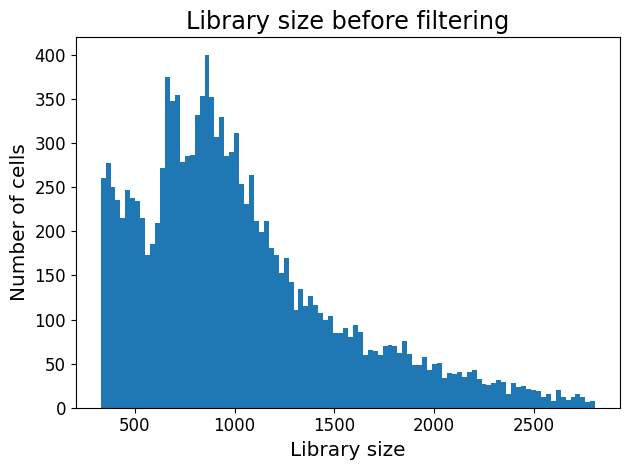

In [394]:
# visualizing library size before filtering
scprep.plot.plot_library_size(entorhinal_cortex_data, log=False, title='Library size before filtering')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

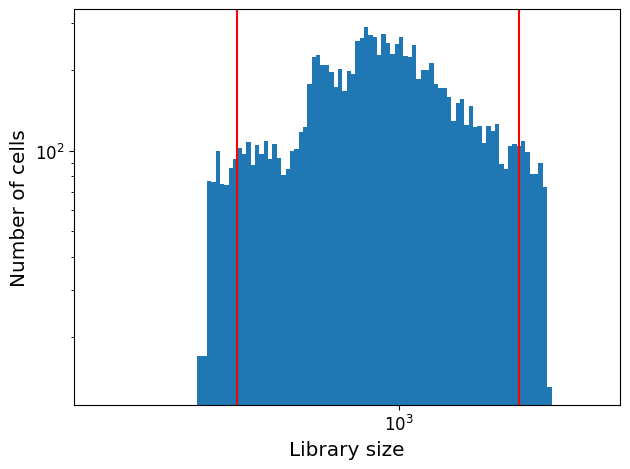

In [395]:
# setting 5TH & 95TH percentiles as library size thresholds
percentiles = (5, 95)
entorhinal_cortex_data, metadata= scprep.filter.filter_library_size(entorhinal_cortex_data, metadata, percentile=percentiles)

# visualizing filtered library
scprep.plot.plot_library_size(entorhinal_cortex_data, percentile=percentiles)

## Filtering lowly expressed genes

Capturing RNA from single cells is a noisy process, leading to a phenomenon called dropout, where lowly expressed genes may not be detected. These genes often lack sufficient observations for meaningful analysis, so they are removed during preprocessing. Typically, genes detected in only a small number of cells (in this case the cutoff is 10) are excluded from the dataset.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Gene capture after filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

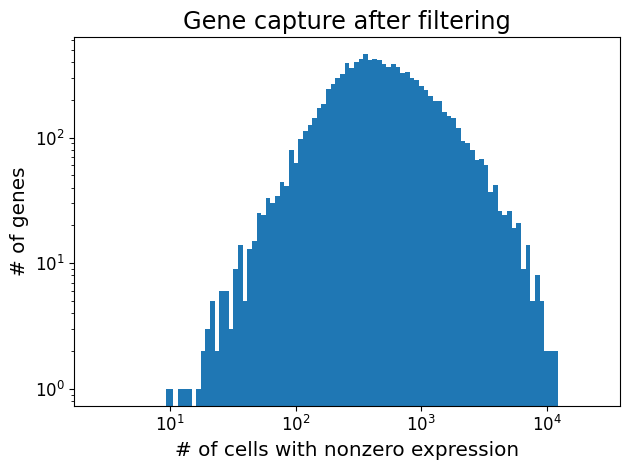

In [396]:
# filter out lowly expressed genes with cutoff of 10
cutoff = 10
entorhinal_cortex_data = scprep.filter.filter_rare_genes(entorhinal_cortex_data, min_cells=cutoff)

#visualize genes capture after filtering
scprep.plot.histogram(scprep.measure.gene_capture_count(entorhinal_cortex_data), 
                       log=True,
                       title="Gene capture after filtering",
                      xlabel='# of cells with nonzero expression',
                      ylabel='# of genes')

## Normalization

To account for differences in library sizes. 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Library size after normalization'}, xlabel='Library size', ylabel='Number of cells'>

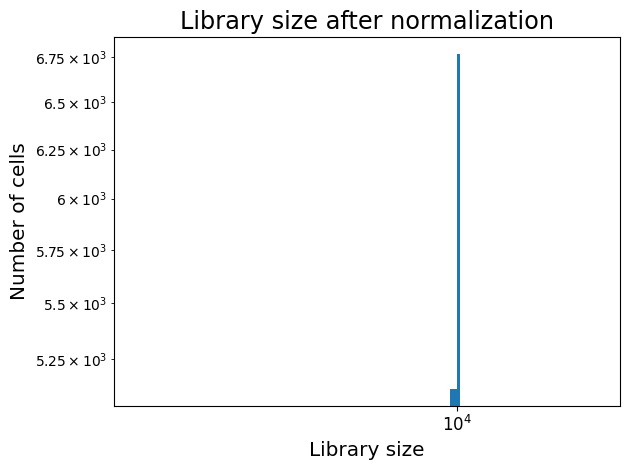

In [397]:
# Normalize data and compute library sizes
entorhinal_cortex_data, metadata['library_size']= scprep.normalize.library_size_normalize(entorhinal_cortex_data, return_library_size=True)

# # Add library sizes to the main DataFrame as a new column
# entorhinal_cortex_data['library_size'] = library_sizes

# Visualize library sizes
scprep.plot.plot_library_size(entorhinal_cortex_data, title='Library size after normalization')

## Gene Count Transformation

In order to avoid these high-expression genes dominating the variation, the data is often transformed. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the function with the added benefit of being stable at 0.



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Gene Counts after Transformation'}, xlabel='Mean Expression Value', ylabel='# of Genes'>

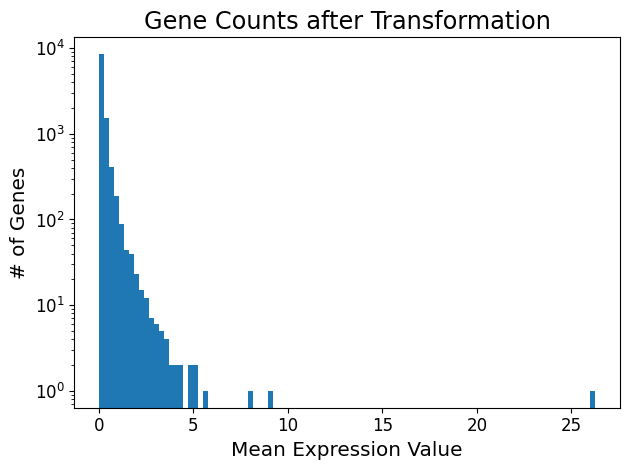

In [398]:
entorhinal_cortex_data = scprep.transform.sqrt(entorhinal_cortex_data)

# visualize

scprep.plot.histogram(entorhinal_cortex_data.mean(axis=0), log='y',
                       title= "Gene Counts after Transformation",
                      xlabel= "Mean Expression Value",
                      ylabel= "# of Genes")

## Saving the Output

In [399]:
## Save the data and metadata dataframes into pickle.gz files you can open later
entorhinal_cortex_data.to_pickle("entorhinal_cortex_data.pickle.gz") #file.pickle.gz
metadata.to_pickle("metadata.pickle.gz")  #file.pickle.gz

## Principle Components Analysis (PCA)

In [400]:
# read in scRNA data
data = pd.read_pickle('entorhinal_cortex_data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')
#run PCA on data
data_pca = scprep.reduce.pca(data, n_components=50, method="dense") 

## Clustering

### Choosing Number of Clusters

I want to use spectral clustering, so I will use a Silhouette score to find the best number of clusters (it measures how well-separated the clusters are). 
More info can be found here: https://scikit-learn.org/dev/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. 

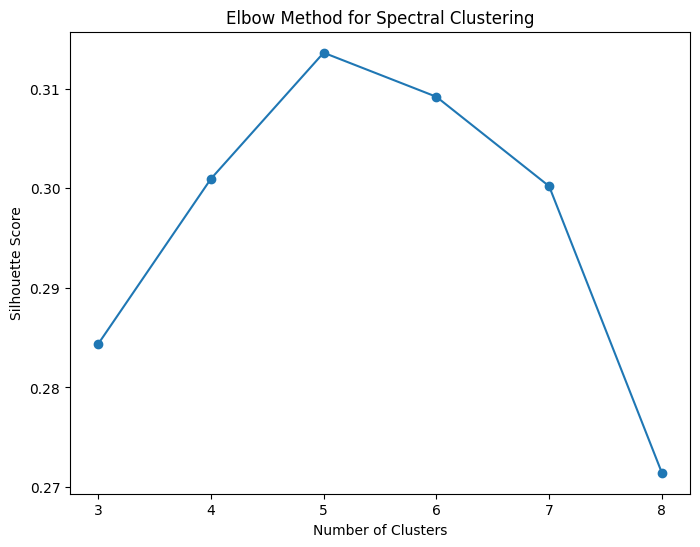

In [401]:
start, end = 3, 8
silhouette_scores = []

# Calculate Silhouette Score (higher is better)
for i in range(start, end + 1):  # Test different cluster counts, Use RBF kernel (default)
    spectral = SpectralClustering(n_clusters=i, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(data_pca)
    
    score = silhouette_score(data_pca, cluster_labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores to find elbow!
plt.figure(figsize=(8, 6))
plt.plot(range(start, end + 1), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Elbow Method for Spectral Clustering")
plt.show()

Based on this graph, the Silhouette score is highest at 5, meaning this is the best number of clusters. 

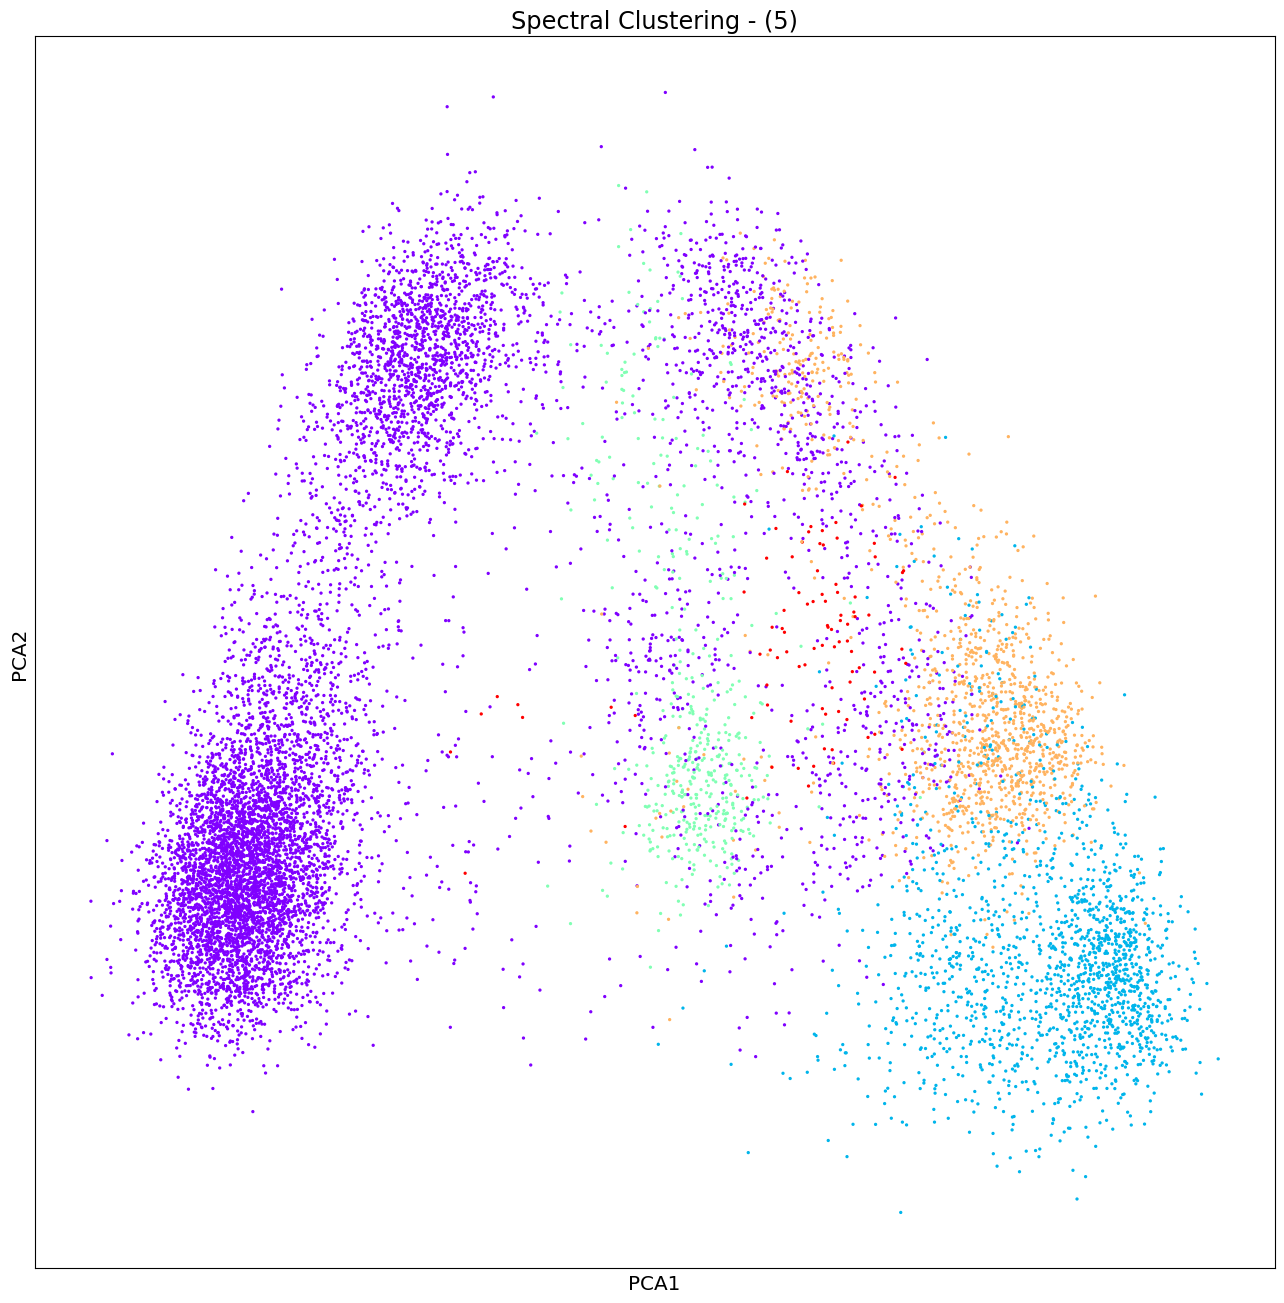

In [429]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

# Perform spectral clustering
spec_op = SpectralClustering(n_clusters=5, affinity='precomputed')
spectral_clusters = spec_op.fit_predict(G.K)

# Create a standalone figure for the spectral plot
fig, ax = plt.subplots(figsize=(16, 16))  

scprep.plot.scatter2d(data_pca,c=spectral_clusters,cmap=plt.cm.rainbow,
                      title="Spectral Clustering - ({})".format(len(np.unique(spectral_clusters))),ticks=False,
                      label_prefix="PCA",legend=False,discrete=True,ax=ax,)

plt.show()


## Research

### Visualize Cell Types:

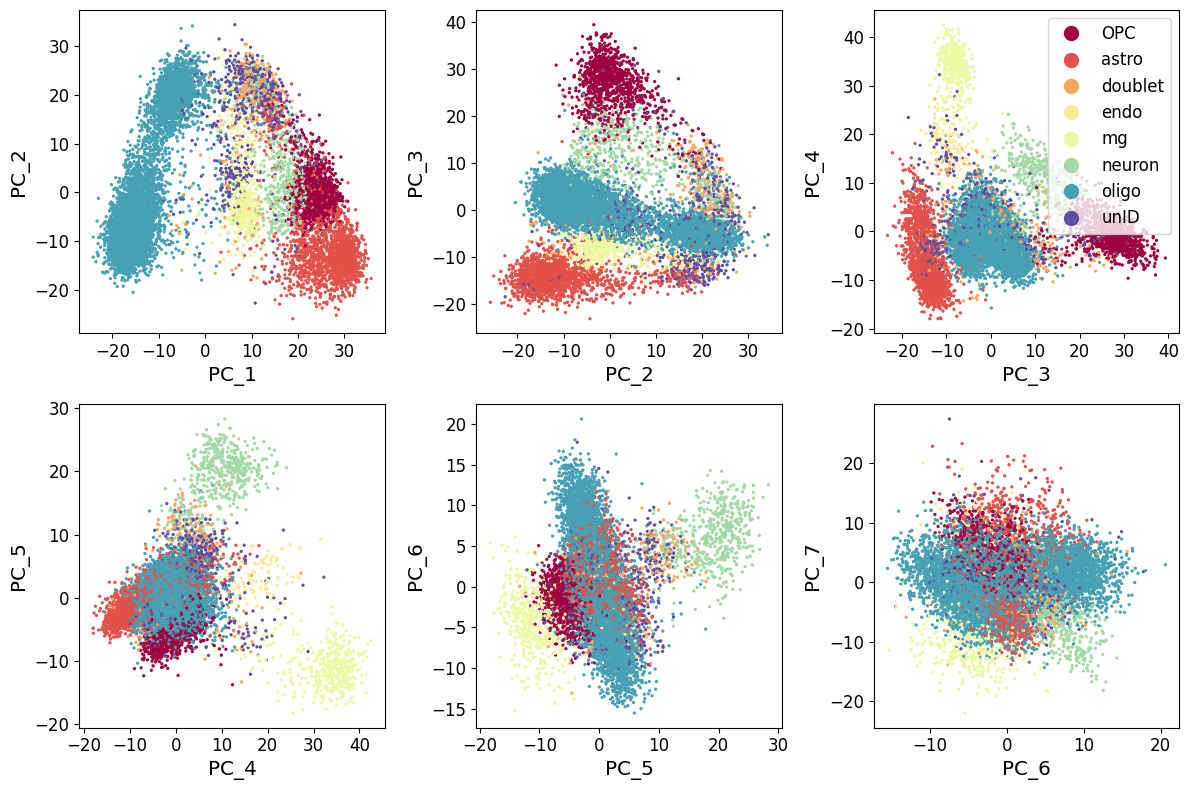

In [403]:
# Let's explore what the different PCs show us!
# We will color our points based on the value in the 'cell type' column in our metadata

fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['oupSample.cellType'],
                        cmap='Spectral', ax=ax,
                        xlabel="PC_" + str(i+1), ylabel="PC_" + str(i+2), legend=legend)
fig.tight_layout() 

### Visualize by Disease State (AD vs Ct):

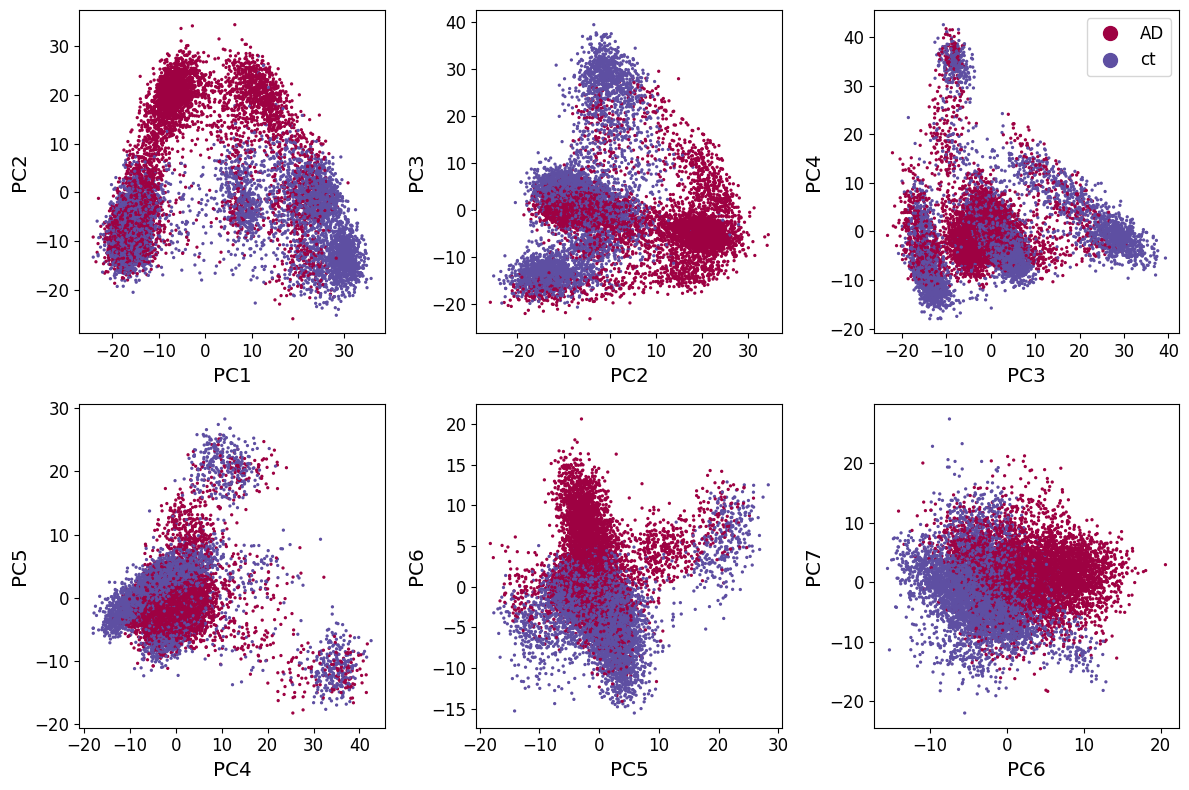

In [422]:
# We will color our points based on the value in the 'batch condition' column in our metadata

fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['oupSample.batchCond'],
                        cmap='Spectral', ax=ax,
                        xlabel="PC" + str(i+1), ylabel="PC" + str(i+2), legend=legend)
fig.tight_layout() 

### Visualize by both Cell Type and Disease State:

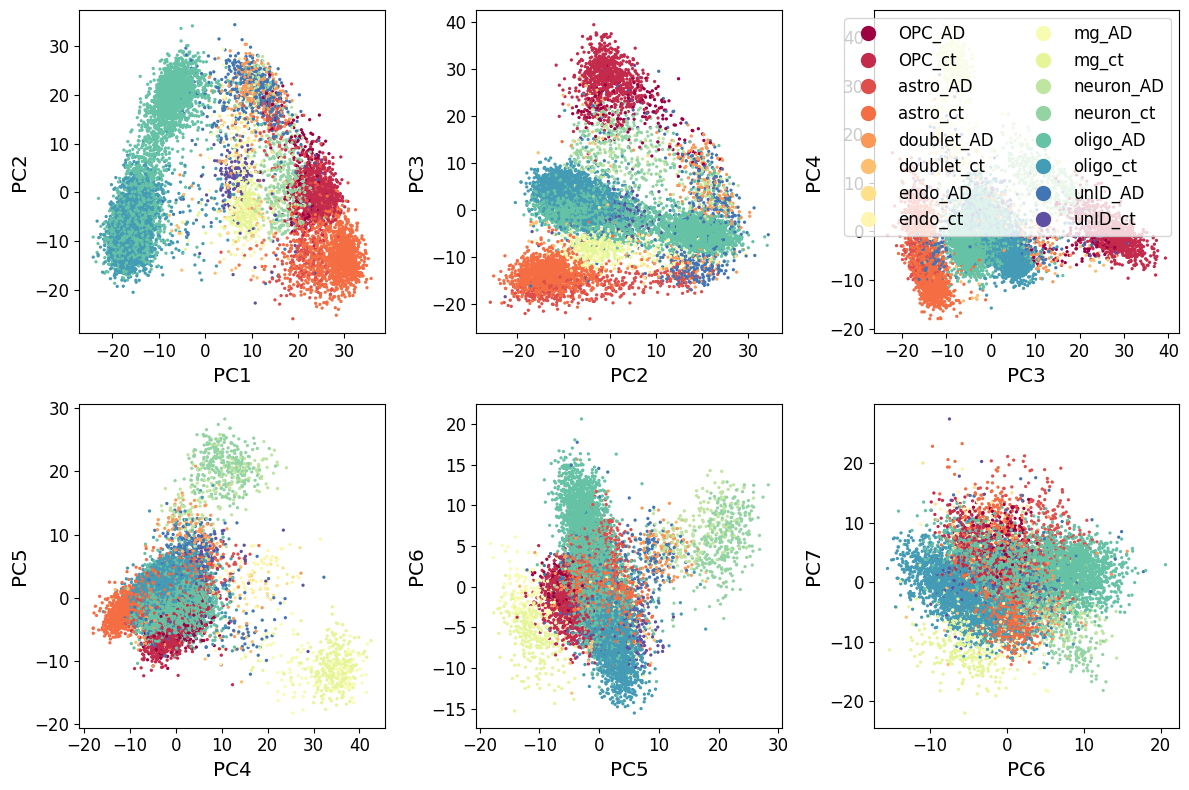

In [421]:
# We will color our points based on the value in the 'oupSample.cellType_batchCond' column in our metadata

fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['oupSample.cellType_batchCond'],
                        cmap='Spectral', ax=ax,
                        xlabel="PC" + str(i+1), ylabel="PC" + str(i+2), legend=legend)
fig.tight_layout() 

That is a bit overwhelming so I want to break it up a bit. First, by looking at AD vs Ct and coloring by cell type.

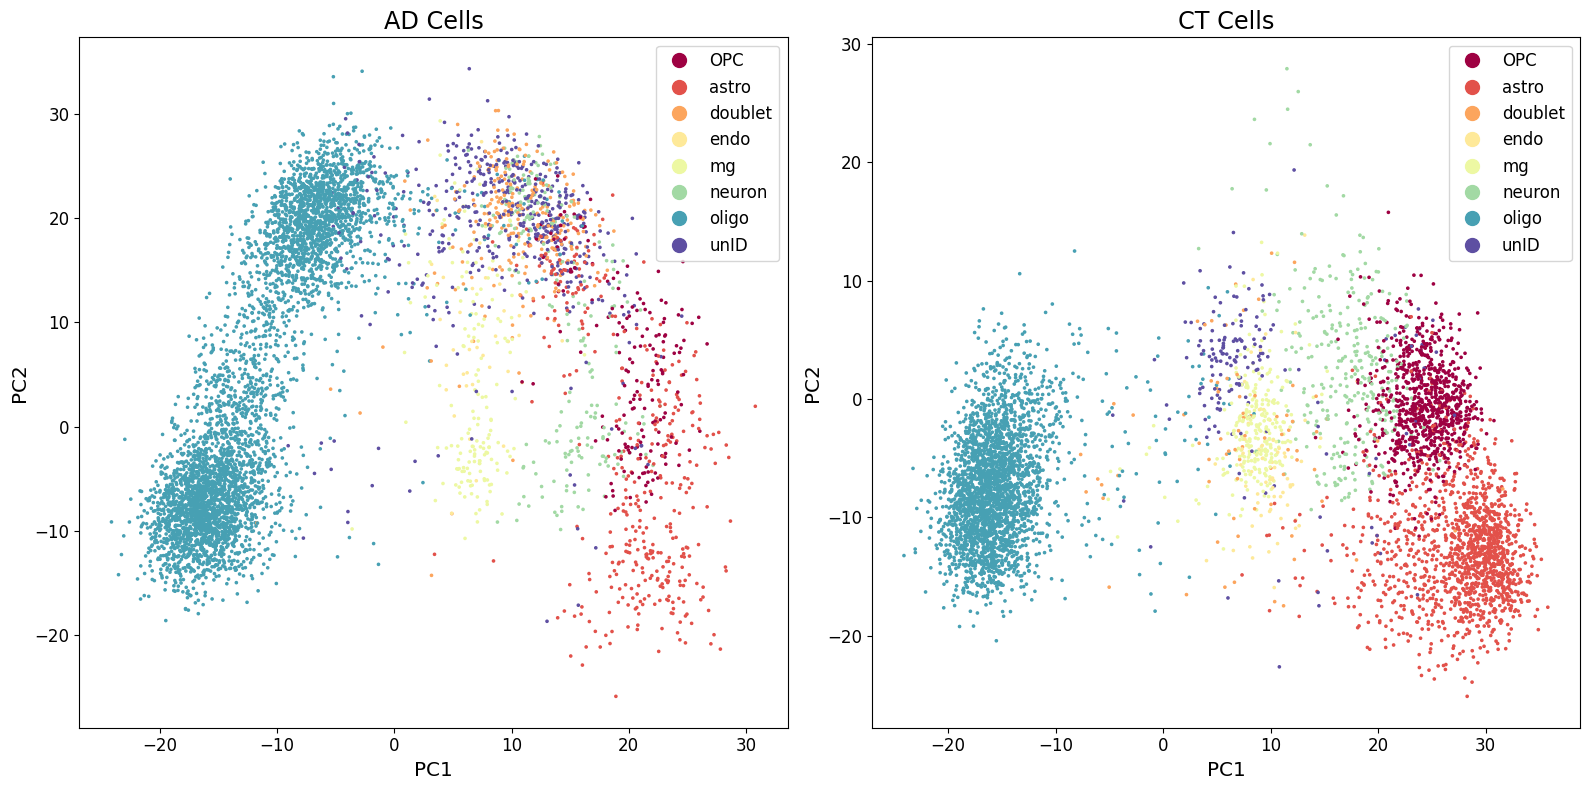

In [428]:
# Subset the data for AD and CT based on batch condition
ad_data = data_pca[metadata['oupSample.batchCond'] == 'AD']
ct_data = data_pca[metadata['oupSample.batchCond'] == 'ct']
ad_metadata = metadata[metadata['oupSample.batchCond'] == 'AD']
ct_metadata = metadata[metadata['oupSample.batchCond'] == 'ct']

# Create scatter plots for AD and CT
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# AD Plot
scprep.plot.scatter(ad_data.iloc[:, 0],ad_data.iloc[:, 1],c=ad_metadata['oupSample.cellType'], 
                    cmap='Spectral',ax=axes[0],label_prefix="PC",title="AD Cells",legend=True)

# CT Plot
scprep.plot.scatter(ct_data.iloc[:, 0], ct_data.iloc[:, 1], c=ct_metadata['oupSample.cellType'], 
                    cmap='Spectral',ax=axes[1],label_prefix="PC", title="CT Cells",legend=True)

# Adjust layout
fig.tight_layout()
plt.show()

Second, I want to plot the cell types and then color by disease state. 

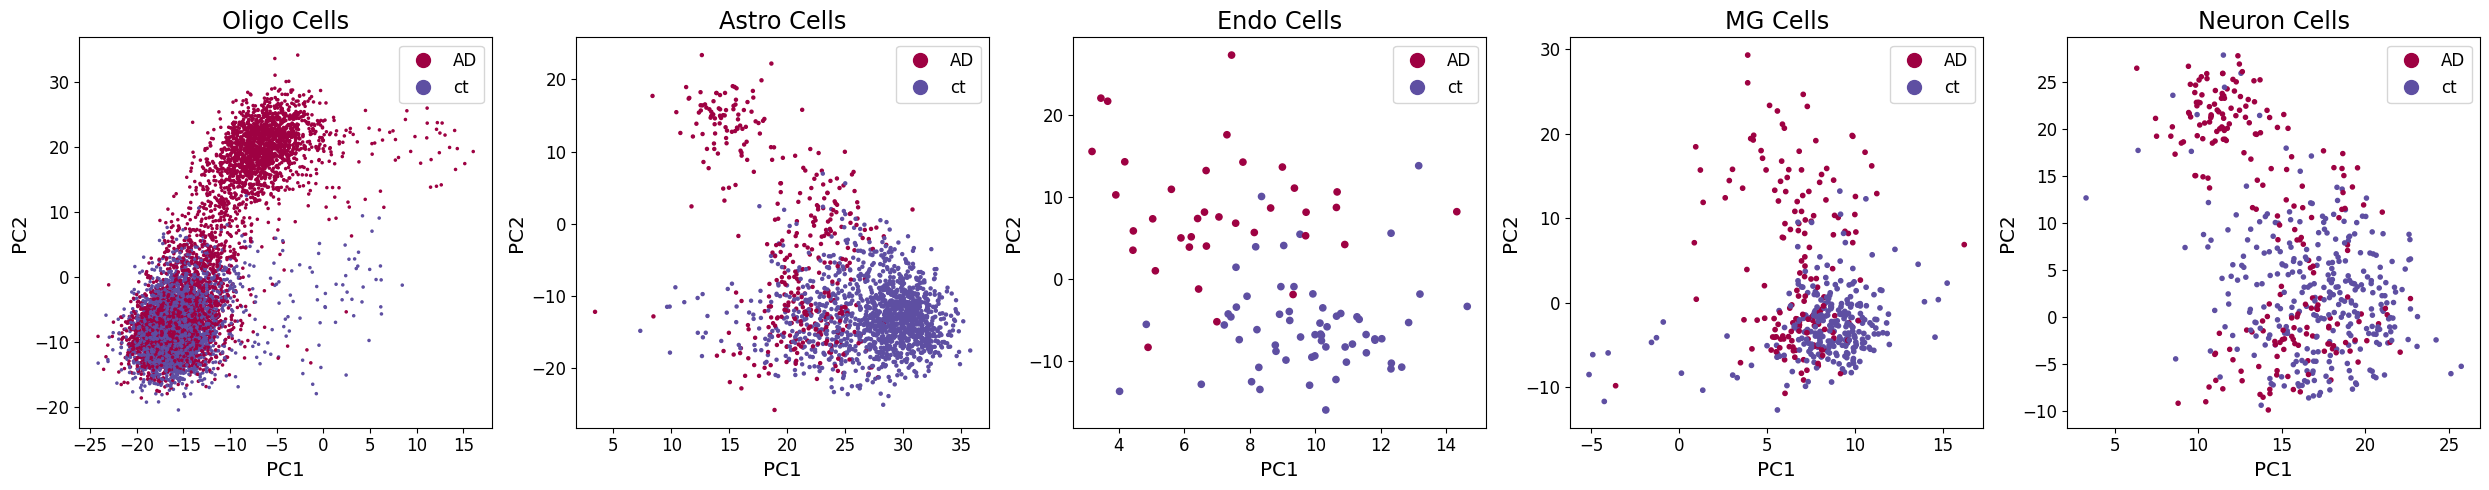

In [426]:
# Subset the data for AD and CT based on batch condition
oligo_pca = data_pca[metadata['oupSample.cellType'] == 'oligo']
astro_pca = data_pca[metadata['oupSample.cellType'] == 'astro']
endo_pca = data_pca[metadata['oupSample.cellType'] == 'endo']
mg_pca = data_pca[metadata['oupSample.cellType'] == 'mg']
neuron_pca = data_pca[metadata['oupSample.cellType'] == 'neuron']


oligo_metadata = metadata[metadata['oupSample.cellType'] == 'oligo']
astro_metadata = metadata[metadata['oupSample.cellType'] == 'astro']
endo_metadata = metadata[metadata['oupSample.cellType'] == 'endo']
mg_metadata = metadata[metadata['oupSample.cellType'] == 'mg']
neuron_metadata = metadata[metadata['oupSample.cellType'] == 'neuron']

# Create scatter plots for AD and CT
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Oligo Plot
scprep.plot.scatter(oligo_pca.iloc[:, 0],  oligo_pca.iloc[:, 1],  c=oligo_metadata['oupSample.batchCond'], 
                    cmap='Spectral', ax=axes[0],label_prefix="PC",title="Oligo Cells",legend=True)

# Astro Plot
scprep.plot.scatter(astro_pca.iloc[:, 0], astro_pca.iloc[:, 1],  c=astro_metadata['oupSample.batchCond'], 
                    cmap='Spectral',ax=axes[1],label_prefix="PC",title="Astro Cells",legend=True)

# Endo Plot
scprep.plot.scatter(endo_pca.iloc[:, 0],  endo_pca.iloc[:, 1],  c=endo_metadata['oupSample.batchCond'], 
                    cmap='Spectral',ax=axes[2],label_prefix="PC",title="Endo Cells",legend=True)

# Mg Plot
scprep.plot.scatter(mg_pca.iloc[:, 0],  mg_pca.iloc[:, 1], c=mg_metadata['oupSample.batchCond'], 
                    cmap='Spectral',ax=axes[3],label_prefix="PC",title="MG Cells",legend=True)

# Neuron Plot
scprep.plot.scatter(neuron_pca.iloc[:, 0],  neuron_pca.iloc[:, 1],  c=neuron_metadata['oupSample.batchCond'], 
                    cmap='Spectral',ax=axes[4],label_prefix="PC",title="Neuron Cells",legend=True)

# Adjust layout
fig.tight_layout()
plt.show()

I see some clear clustering of AD and Control cells in some cell types (e.g., Oligo and Astro). This may indicate potential differences in gene expression patterns for these cell types between AD and CT groups.
Other cell types, like Endo and MG, show more overlap, suggesting less clear distinction. Let's perform differential expression analysis on these cell types to uncover genes driving the observed patterns.


## Differential Expression

Differential Expression Analysis comparing the gene expression values of "AD" cells and "CT" cells for the current cell type.


In [409]:
# List of cell types
cell_types = ['oligo', 'astro', 'endo', 'mg', 'neuron']

for cell_type in cell_types:
    data_var_name = f"{cell_type}_data"
    metadata_var_name = f"{cell_type}_metadata"

    # Create dynamically named variables for cell data - to be used in later cells!
    globals()[data_var_name] = data_sparse[metadata['oupSample.cellType'] == cell_type]
    globals()[metadata_var_name] = metadata[metadata['oupSample.cellType'] == cell_type]
    
    # Perform differential expression analysis between AD and CT conditions
    ad_indices = globals()[metadata_var_name]['oupSample.batchCond'] == 'AD'
    ct_indices = globals()[metadata_var_name]['oupSample.batchCond'] == 'ct'
    ttest_results = scprep.stats.differential_expression(
        globals()[data_var_name][ad_indices],
        globals()[data_var_name][ct_indices],
        measure="ttest"
    )
    
    # Get the top 5 genes for the current cell type
    top_genes = ttest_results['ttest'].sort_values(ascending=False)[:5]
    
    print(f"Top 5 genes for {cell_type}:")
    print(top_genes)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Top 5 genes for oligo:
LINC00486    66.011895
LINGO1       64.696926
NEAT1        50.171528
HSPA1A       38.364201
FKBP5        36.076992
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Top 5 genes for astro:
NEAT1        32.850296
GFAP         23.250302
LINGO1       22.083124
LINC00486    15.004552
HIF3A        13.202634
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Top 5 genes for endo:
LINC00486    10.710589
LINGO1        9.727574
MT-ND2        6.497231
IFITM3        4.902663
IFITM2        4.876568
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Top 5 genes for mg:
FKBP5        13.112715
LINC00486    11.642016
LINGO1       10.434040
NEAT1         9.806177
DPYD          9.737627
Name: ttest, dtype: float64
Top 5 genes for neuron:
LINGO1       15.817301
HSPA1A        9.609716
LINC00486     9.576602
SPP1          9.234787
GFAP          7.779364
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


## Directional Differential Analysis - are the genes downregulated or upregulated in AD cells?

To identify whether genes are upregulated or downregulated in Alzheimer's Disease (AD) cells compared to control (CT) cells, I used the scprep.stats.differential_expression function. 

This calculates a directional metric by comparing the gene expression levels between the two conditions. Genes with higher expression in AD cells (X_AD > Y_CT) are considered upregulated, while genes with lower expression in AD cells (X_AD < Y_CT) are considered downregulated. This directional approach provides insights into how specific genes behave differently across cell types under the influence of Alzheimer's Disease.



In [412]:
for cell_type in cell_types:

    data_var_name = f"{cell_type}_data"
    metadata_var_name = f"{cell_type}_metadata"
    
    # Access the dynamically created variables from globals()
    cell_data = globals()[data_var_name]
    cell_metadata = globals()[metadata_var_name]
    
    # Perform differential expression analysis between AD and CT conditions
    ad_indices = cell_metadata['oupSample.batchCond'] == 'AD' # this is our X
    ct_indices = cell_metadata['oupSample.batchCond'] == 'ct' # this is our Y
    ttest_results = scprep.stats.differential_expression(
        cell_data[ad_indices],
        cell_data[ct_indices],
        measure="ttest", 
        direction="up" # "up" variable added for directional t-test!
    )
    
    # Get the top 5 genes with the largest positive or negative t-statistic
    top_genes = ttest_results['ttest'].sort_values(ascending=False)[:2]  # Most upregulated in AD
    bottom_genes = ttest_results['ttest'].sort_values(ascending=True)[:2]  # Most downregulated in AD

    print("Upregulated in AD for", cell_type)
    print(top_genes)

    print("Downregulated in AD for", cell_type)
    print(bottom_genes)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Upregulated in AD for oligo
LINC00486    66.011895
LINGO1       64.696926
Name: ttest, dtype: float64
Downregulated in AD for oligo
IL1RAPL1   -37.722343
MALAT1     -35.571471
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Upregulated in AD for astro
NEAT1    32.850296
GFAP     23.250302
Name: ttest, dtype: float64
Downregulated in AD for astro
NRXN1    -28.557988
NKAIN3   -25.162899
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Upregulated in AD for endo
LINC00486    10.710589
LINGO1        9.727574
Name: ttest, dtype: float64
Downregulated in AD for endo
PTN       -7.200781
SLC7A11   -7.052021
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


Upregulated in AD for mg
FKBP5        13.112715
LINC00486    11.642016
Name: ttest, dtype: float64
Downregulated in AD for mg
LPAR6           -9.633561
RP11-480C22.1   -9.153452
Name: ttest, dtype: float64
Upregulated in AD for neuron
LINGO1    15.817301
HSPA1A     9.609716
Name: ttest, dtype: float64
Downregulated in AD for neuron
ANKS1B   -7.781226
RIMS1    -7.741646
Name: ttest, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in divide
  return mean_difference(X, Y) / paired_std


## Visualize Gene Expression

For each cell type, I  visualized the top two upregulated and downregulated genes between Alzheimer's Disease (AD) and control (CT) groups. 

These visualizations display the gene expression levels on a PCA plot, highlighting how these genes are differentially expressed across conditions. Each plot is labeled with the gene name, the cell type, and whether it is upregulated or downregulated in AD cells, providing a clear and concise view of condition-specific gene expression patterns.



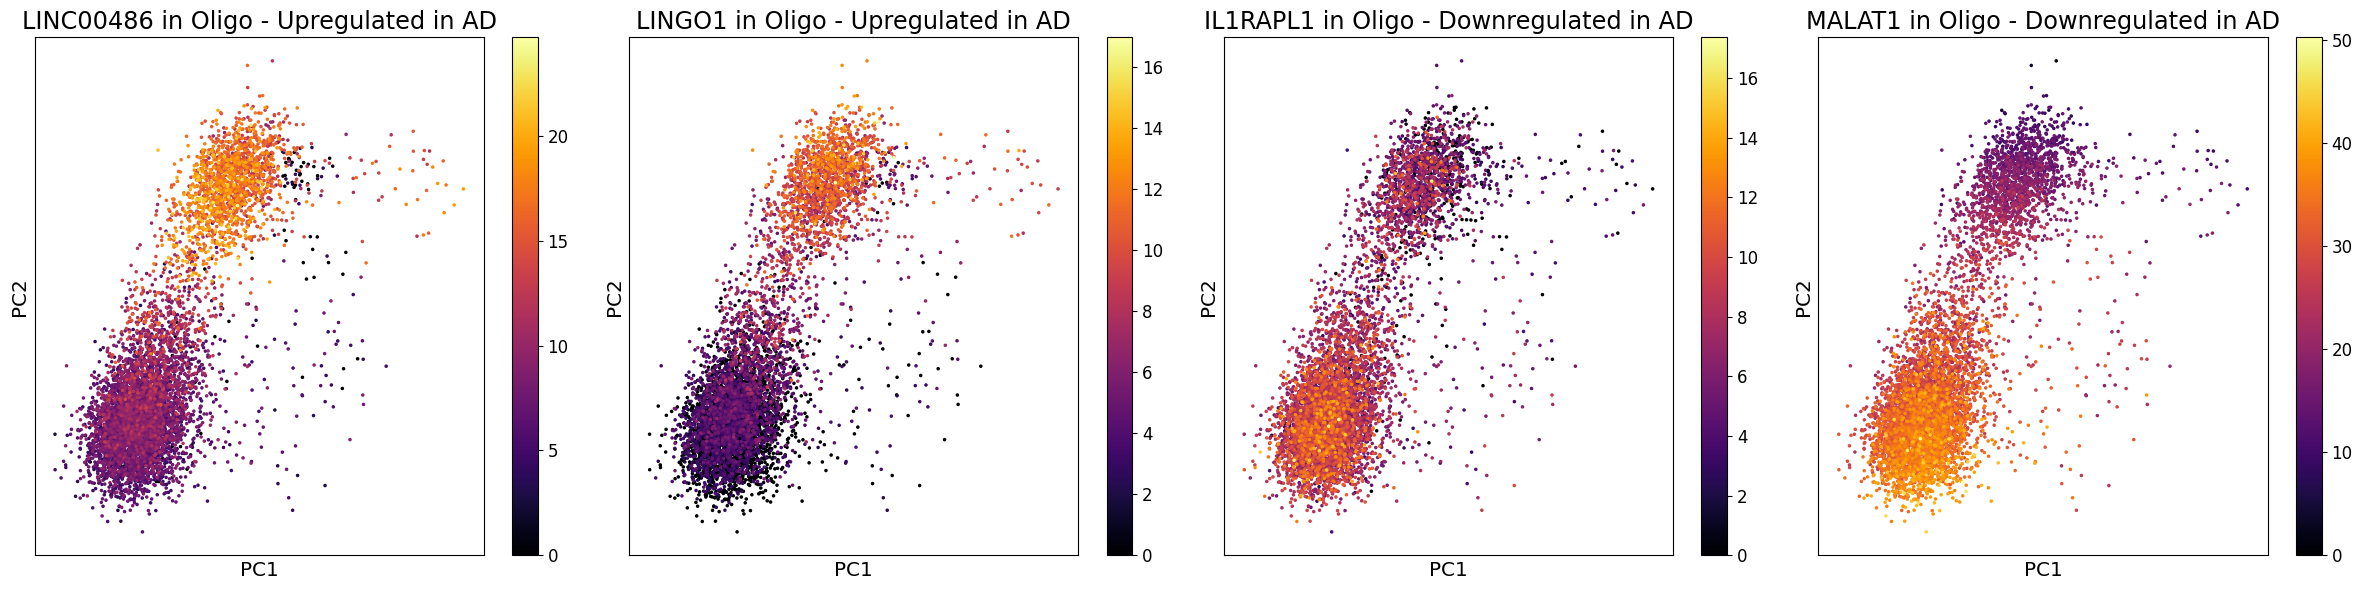

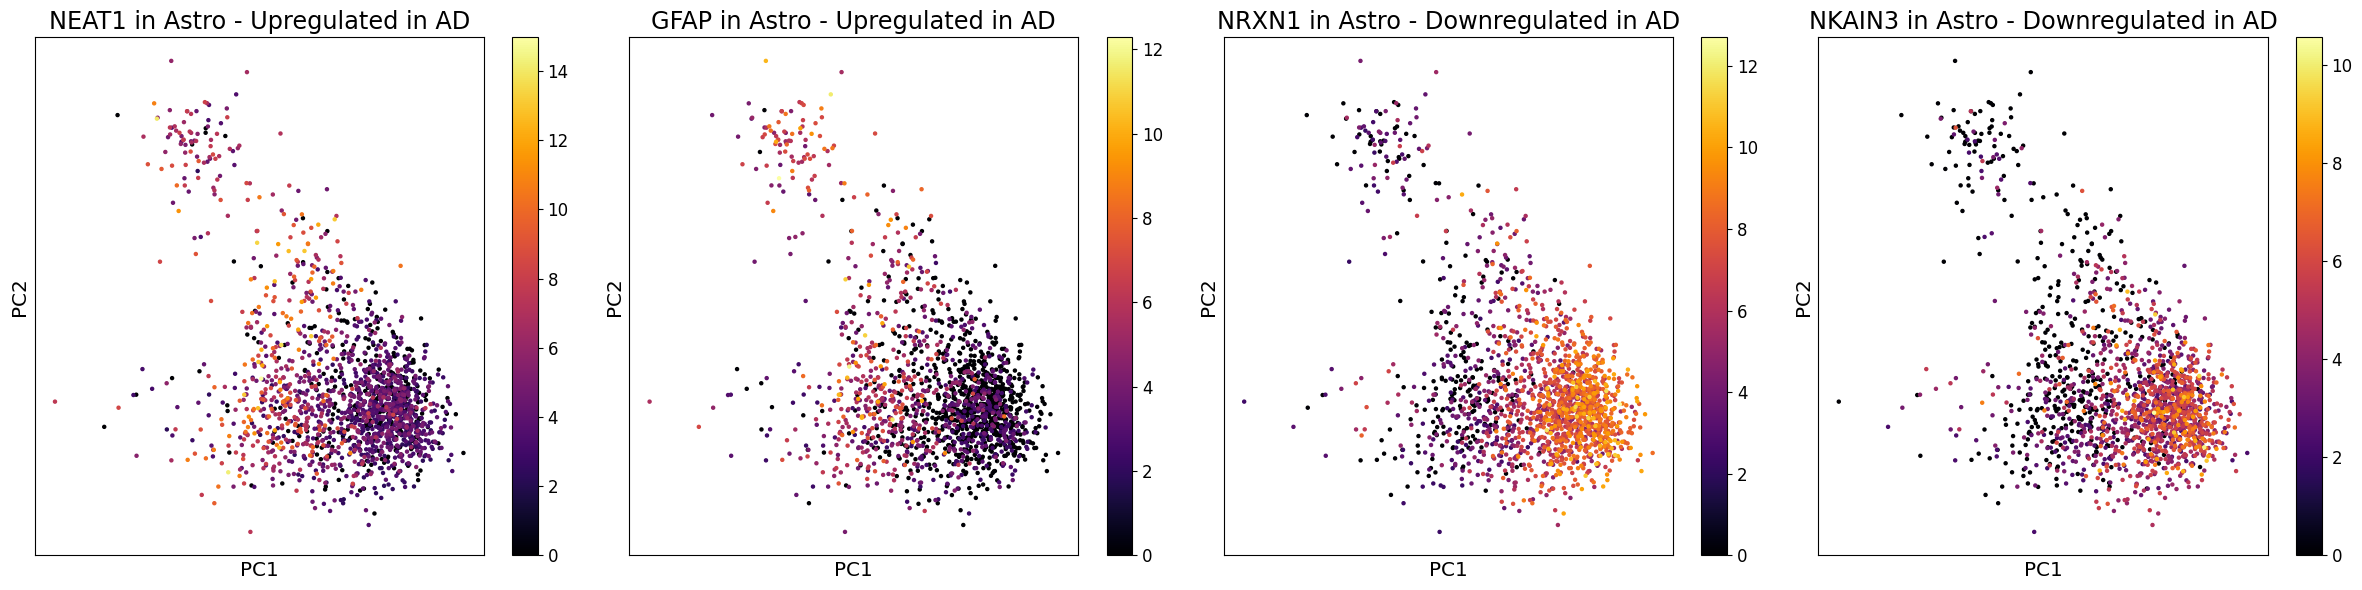

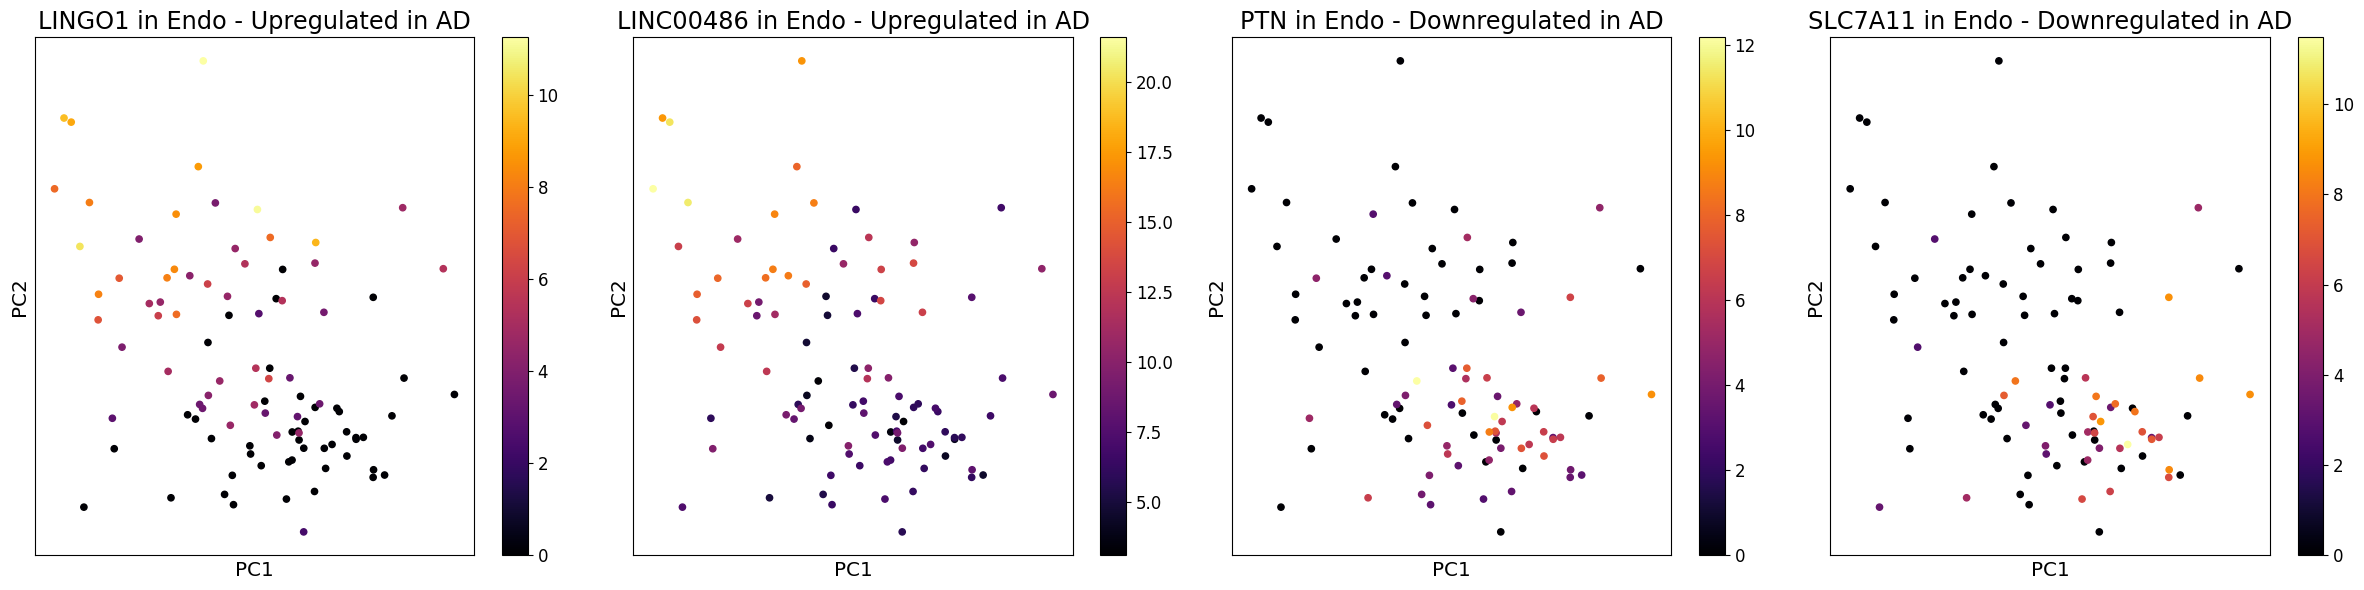

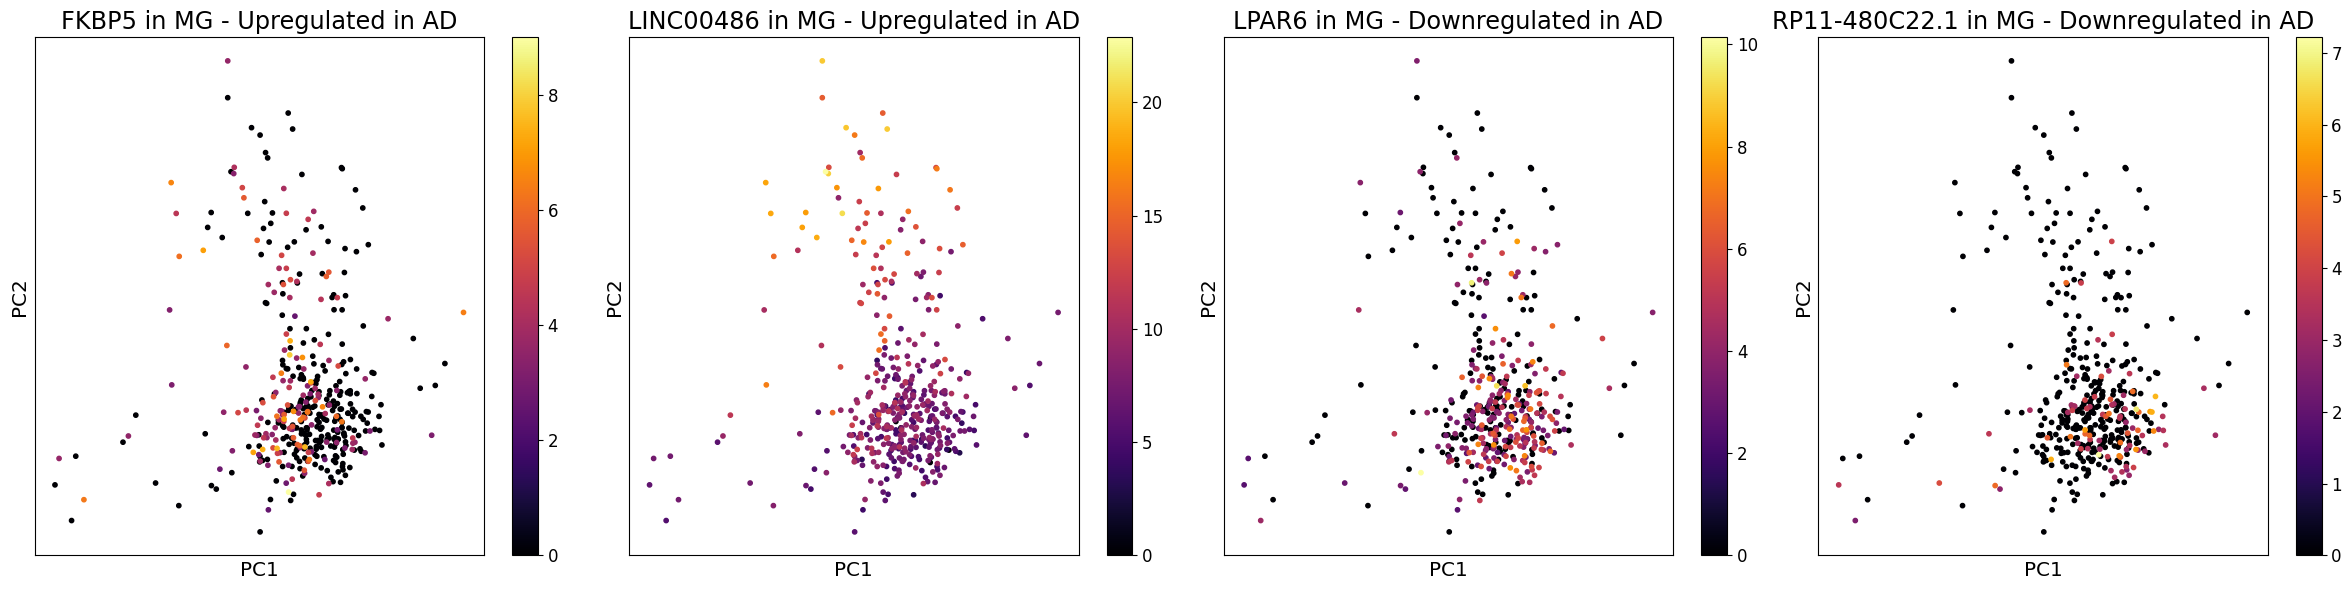

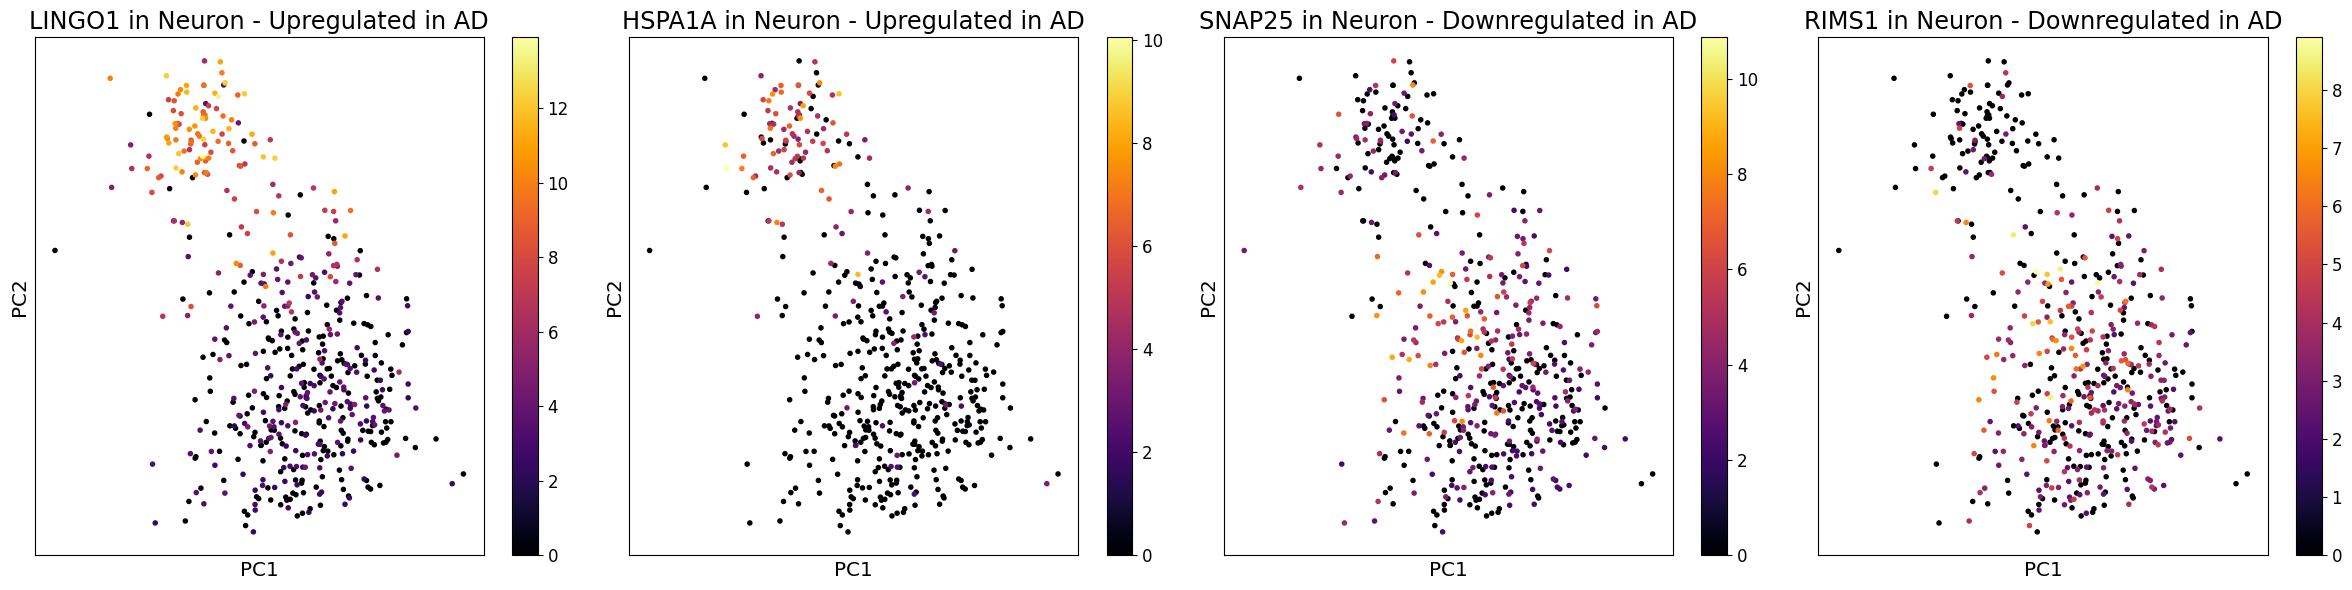

In [425]:
def plot_genes_by_cell_type(upregulated_genes, downregulated_genes, gene_expression_data, data_pca, cell_type):
    # Combine upregulated and downregulated genes into a single list with labels, so that we can plot them together!
    gene_info = [
        (gene, "Upregulated") for gene in upregulated_genes # upregulated = direction (to be added to plot title)
    ] + [
        (gene, "Downregulated") for gene in downregulated_genes # same for downregulated
    ]
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 6), squeeze=False)
    axes = axes.flatten()

    for i, (gene, direction) in enumerate(gene_info):

        expression = gene_expression_data[gene]
        sort_index = expression.sort_values().index

        scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False, 
                              title=f"{gene} in {cell_type} - {direction} in AD",ticks=None,label_prefix="PC",ax=axes[i])

    fig.tight_layout()
    plt.show()


oligo_upregulated = ["LINC00486", "LINGO1"]
oligo_downregulated = ["IL1RAPL1", "MALAT1"]
astro_upregulated =["NEAT1", "GFAP"]
astro_downregulated = ["NRXN1", "NKAIN3"]
endo_upregulated = ["LINGO1", "LINC00486"]
endo_downregulated = ["PTN", "SLC7A11"]
mg_upregulated =["FKBP5", "LINC00486"]
mg_downregulated = ["LPAR6", "RP11-480C22.1"]
neuron_upregulated = ["LINGO1", "HSPA1A"]
neuron_downregulated = ["SNAP25", "RIMS1"]

plot_genes_by_cell_type(
    upregulated_genes=oligo_upregulated,
    downregulated_genes=oligo_downregulated,
    gene_expression_data=oligo_data,  
    data_pca=oligo_pca,         
    cell_type="Oligo"
)

plot_genes_by_cell_type(
    upregulated_genes=astro_upregulated,
    downregulated_genes=astro_downregulated,
    gene_expression_data=astro_data,  
    data_pca=astro_pca,         
    cell_type="Astro"
)

plot_genes_by_cell_type(
    upregulated_genes=endo_upregulated,
    downregulated_genes=endo_downregulated,
    gene_expression_data=endo_data,  
    data_pca=endo_pca,         
    cell_type="Endo"
)

plot_genes_by_cell_type(
    upregulated_genes=mg_upregulated,
    downregulated_genes=mg_downregulated,
    gene_expression_data=mg_data,  
    data_pca=mg_pca,         
    cell_type="MG"
)

plot_genes_by_cell_type(
    upregulated_genes=neuron_upregulated,
    downregulated_genes=neuron_downregulated,
    gene_expression_data=neuron_data,  
    data_pca=neuron_pca,         
    cell_type="Neuron"
)


